In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Example system

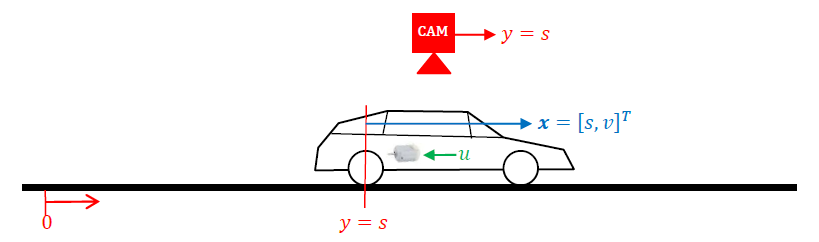

State space equations:

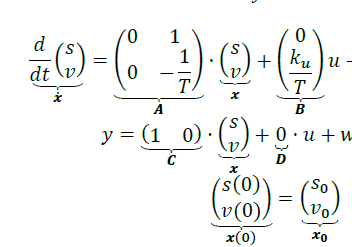

In [5]:
T = 0.300 # s 
ku = 2.51 # m/s

In [6]:
A = np.asarray([[0, 1], 
                [0, -1/T]])

In [7]:
B = np.asarray([[0], 
                [ku/T]])

In [8]:
C = np.array([1, 0])

In [9]:
D = 0

## Initial conditions

In [10]:
x0 = np.array([[0], [0]])

In [11]:
x0

array([[0],
       [0]])

## Simulation time settings

In [54]:
TA = 0.01  # sampling time

In [55]:
T_end = 10 # [0s, T_end s]

In [56]:
n_timesteps = int(1+T_end//TA)

In [57]:
n_timesteps

1000

# Simulation of cont. LTI state-space

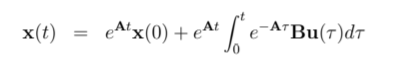

from http://web.mit.edu/2.14/www/Handouts/StateSpaceResponse.pdf (Derek Rowell, MIT, 2002)

In [58]:
from scipy.linalg import expm
from sympy import Symbol, Matrix, integrate, MatMul
import sympy as sp
from sympy import symbols

## Symbolic integration

The following cells use `sympy` to create a symbolic integral.

In [59]:
tau_symbol = Symbol("\tau")
t_symbol = Symbol("t")
integral_0_t = integrate(MatMul(sp.exp(-Matrix(A)*tau_symbol), Matrix(B)), (tau_symbol, 0, t_symbol))

In [60]:
integral_0_t

Matrix([
[2.51*t - 0.753*exp(3.33333333333333*t) + 0.753],
[           2.51*exp(3.33333333333333*t) - 2.51]])

Time vector for calculation:

In [66]:
timesteps = np.arange(0, T_end, TA)

In [67]:
u_k = 1*np.ones_like(timesteps) # step function input

In [68]:
def calculate_x(t):
    integral_value = np.array(integral_0_t.subs(t_symbol, t)).astype(np.float64)
    return expm(A*t) @ x0 + expm(A*t) @ integral_value

In [69]:
x_continuous = np.zeros((2, n_timesteps))

In [70]:
for i in tqdm(range(n_timesteps)):
    x_continuous[:, i] = calculate_x(timesteps[i]).reshape((2,))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.37it/s]


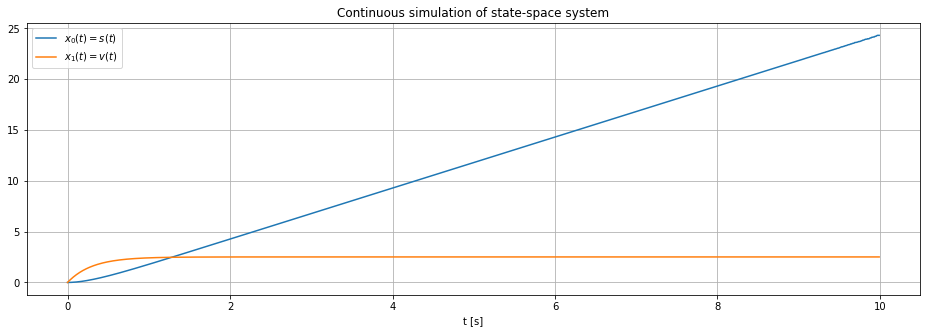

In [71]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, x_continuous[0, :], label="$x_0(t)=s(t)$")
plt.plot(timesteps, x_continuous[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Continuous simulation of state-space system");

# Discretization


## Literature (Marchtaler)

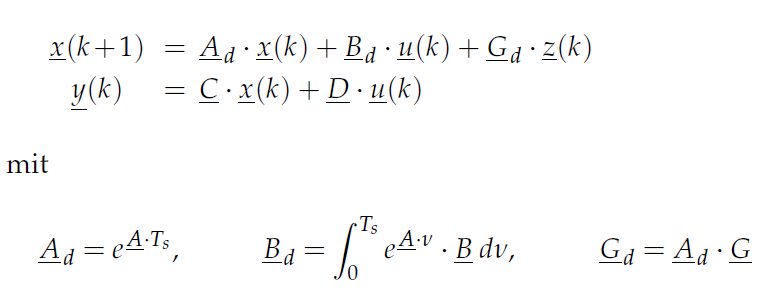

In [72]:
from scipy.linalg import expm

In [73]:
Ad = expm(A*TA)
Ad

array([[1.        , 0.00983517],
       [0.        , 0.9672161 ]])

In [74]:
v = Symbol("v")
Bd = np.asarray(integrate(MatMul(sp.exp(Matrix(A*v)), Matrix(B)), (v, 0, TA)), dtype=np.float64)
Bd

array([[0.00041372],
       [0.08228759]])

In [78]:
x_marchtaler = np.zeros((2, n_timesteps))

In [79]:
# set x(0)
x_marchtaler[:, 0] = x0.reshape((2,))

In [80]:
Ad @ x_marchtaler[:, 0:1]

array([[0.],
       [0.]])

In [81]:
for k in range(1, n_timesteps, 1):
    x_k = Ad @ x_marchtaler[:, k-1].reshape((2,1)) + Bd # with 1=u(k) = 1
    x_marchtaler[:, k] =  x_k.reshape((2,))

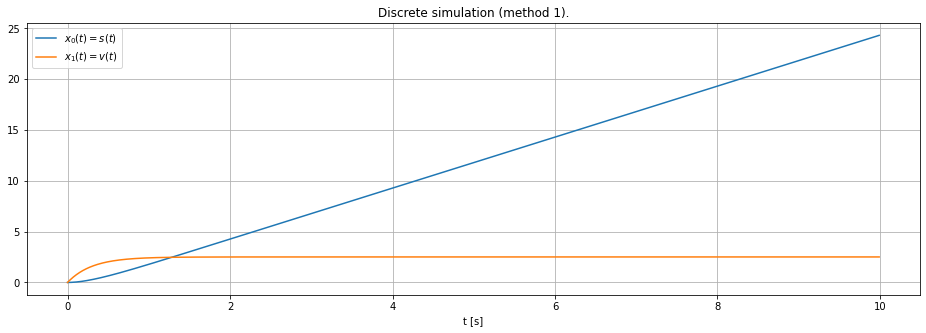

In [82]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, x_marchtaler[0, :], label="$x_0(t)=s(t)$")
plt.plot(timesteps, x_marchtaler[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (method 1).");


## Backward Euler

Via Backward Euler method, see https://en.wikipedia.org/wiki/Backward_Euler_method

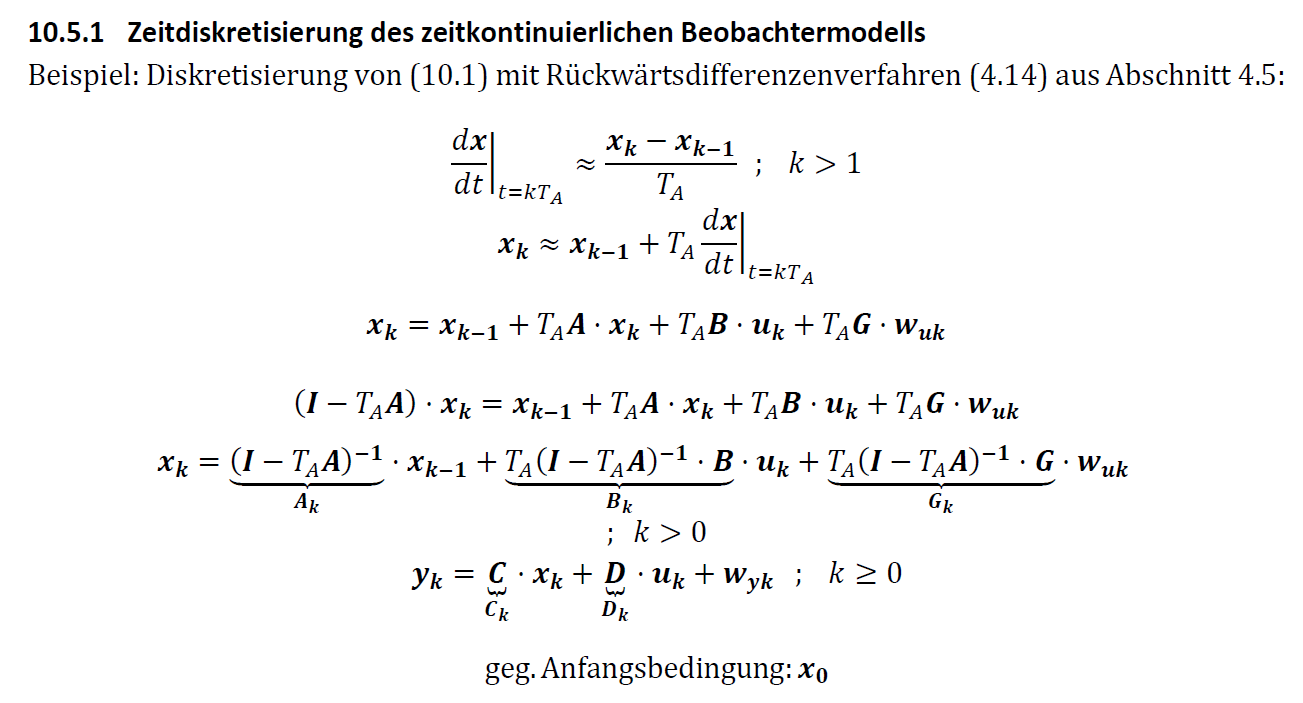

In [83]:
from scipy.linalg import inv

In [84]:
Ak = inv(np.eye(2) - TA*A)
Ak

array([[1.        , 0.00967742],
       [0.        , 0.96774194]])

In [85]:
Bk = TA*Ak @ B
Bk

array([[0.00080968],
       [0.08096774]])

In [86]:
x_backward = np.zeros((2, n_timesteps))

In [87]:
# set x(0)
x_backward[:, 0] = x0.reshape((2,))

In [88]:
for k in range(1, n_timesteps, 1):
    x_k = Ak @ x_backward[:, k-1].reshape((2,1)) + Bk # with 1=u(k) = 1
    x_backward[:, k] =  x_k.reshape((2,))

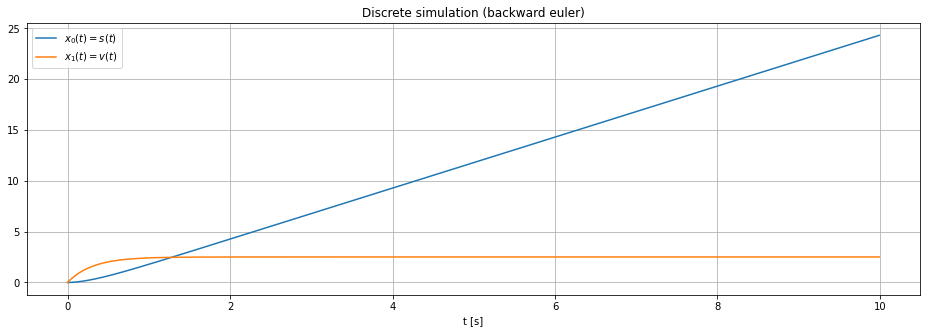

In [89]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, x_backward[0, :], label="$x_0(t)=s(t)$")
plt.plot(timesteps, x_backward[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (backward euler)");

## Trapezoidal integration

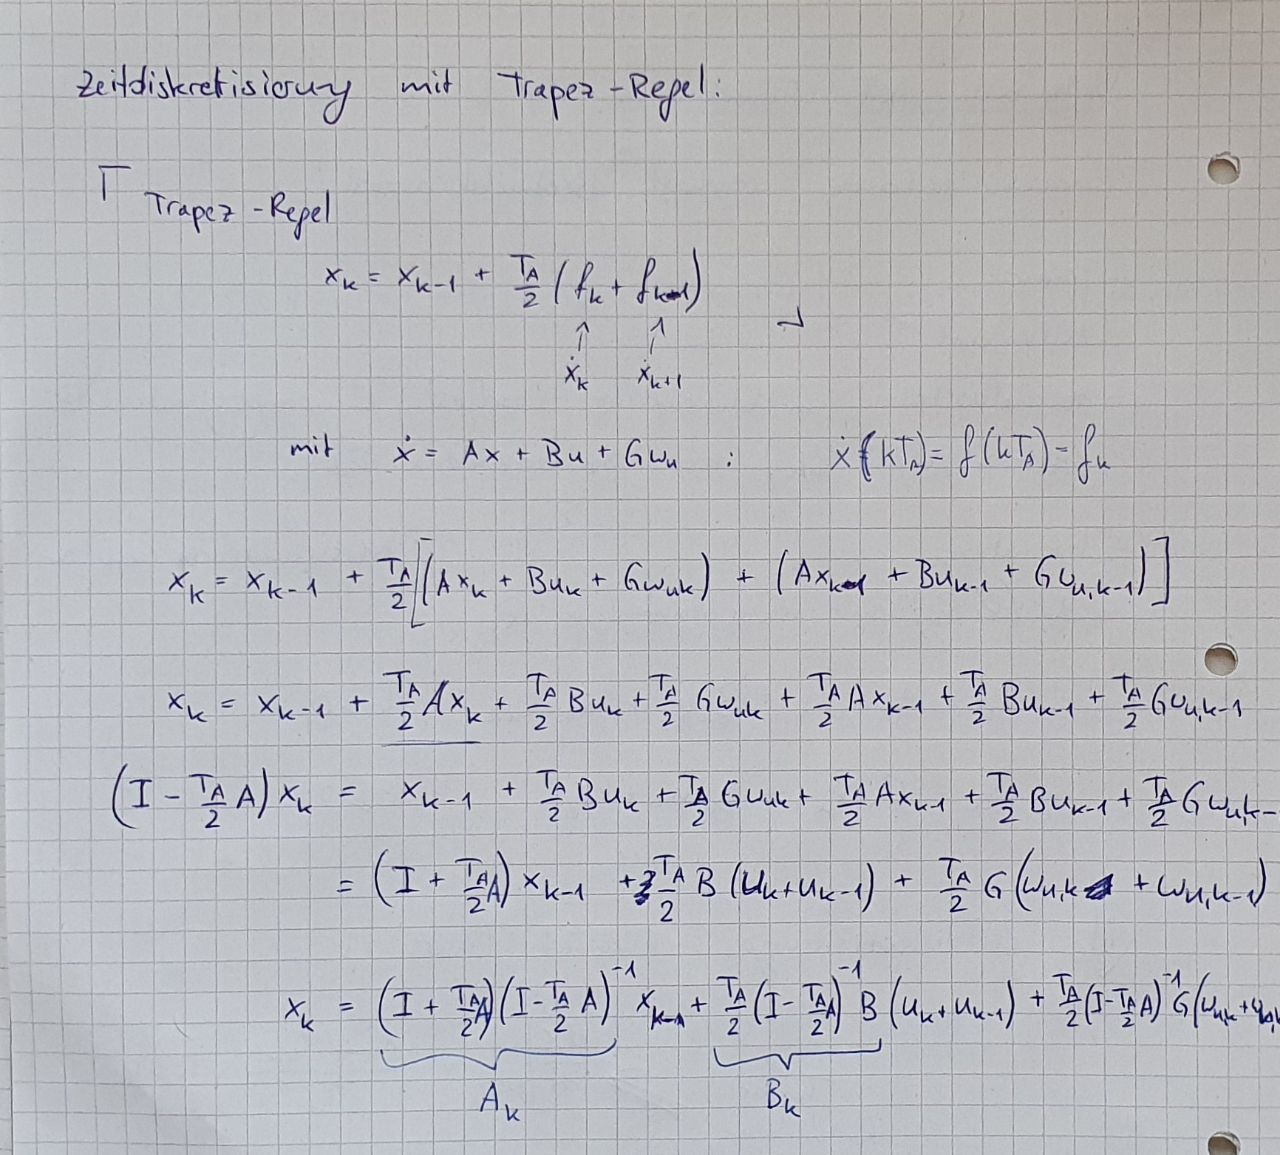

In [90]:
Ak = inv(np.eye(2) - TA*A/2) @ (np.eye(2) + TA*A/2)

In [91]:
Bk = inv(np.eye(2) - TA*A/2)*TA/2 @ B

In [92]:
x_trapez = np.zeros((2, n_timesteps))

In [93]:
# set x(0)
x_trapez[:, 0] = x0.reshape((2,))

In [95]:
for k in range(1, n_timesteps, 1):
    x_k = Ak @ x_trapez[:, k-1].reshape((2,1)) + Bk*2# with 1=u(k) = 1
    x_trapez[:, k] =  x_k.reshape((2,))

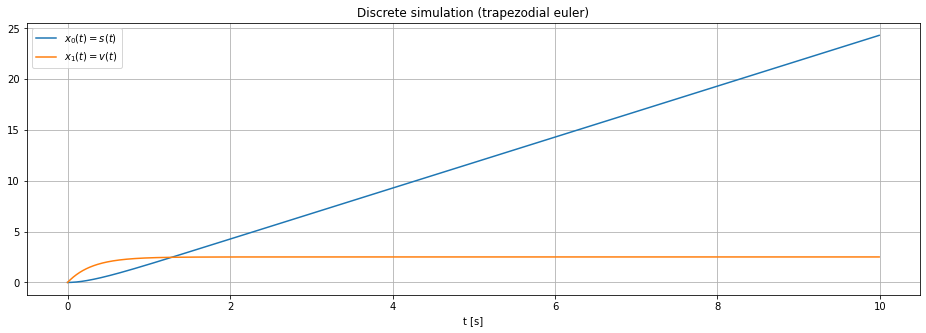

In [97]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, x_trapez[0, :], label="$x_0(t)=s(t)$")
plt.plot(timesteps, x_trapez[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (trapezodial euler)");

# Method comparison

In [98]:
from numpy.linalg import norm

Calculate euclidean norm between the discrete methods and the continuous methods

In [104]:
error_marchtaler = norm(x_marchtaler-x_continuous, axis=0)

In [105]:
error_backward = norm(x_backward-x_continuous, axis=0)

In [106]:
error_trapez = norm(x_trapez-x_continuous, axis=0)

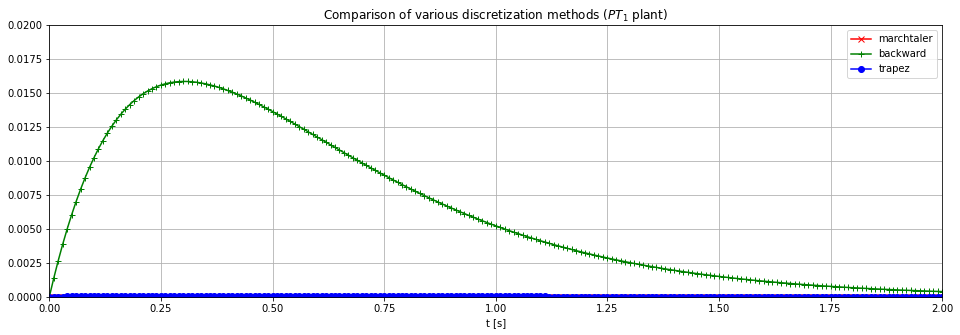

In [120]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, error_marchtaler, "rx-", label="marchtaler")
plt.plot(timesteps, error_backward, "g+-", label="backward")
plt.plot(timesteps, error_trapez, "bo-", label="trapez")
plt.legend()
plt.xlabel("t [s]")
plt.xlim([0, 2])
plt.ylim([0, 0.020])
plt.grid()
plt.title("Comparison of various discretization methods ($PT_1$ plant)");

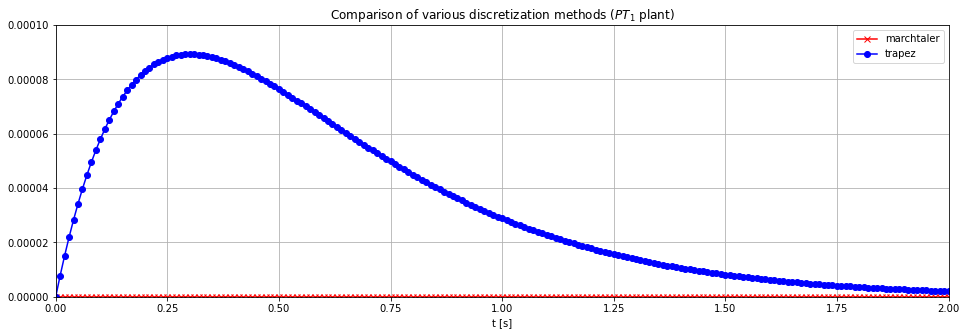

In [122]:
plt.figure(figsize=(16, 5))
plt.plot(timesteps, error_marchtaler, "rx-", label="marchtaler")
plt.plot(timesteps, error_trapez, "bo-", label="trapez")
plt.legend()
plt.xlabel("t [s]")
plt.xlim([0, 2])
plt.ylim([0, 0.0001])
plt.grid()
plt.title("Comparison of various discretization methods ($PT_1$ plant)");